In [2]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from scipy.ndimage import gaussian_filter
from scipy.stats import kurtosis
from numpy import hamming  # Import hamming window function
import csv
import re
import seaborn as sns
from matplotlib import colors

# Define the directory containing the FITS files
directory = r"C:\Users\lsann\Desktop\TESTPREP\REAL CUBES"

# Directory to save the outputs
output_dir = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Read the CSV file and create a dictionary
beam_size_dict = {}
csv_file_path = r"C:\Users\lsann\Desktop\GitHub\ALMASim\almasim\metadata\calculated_params.csv"

with open(csv_file_path, mode='r', newline='') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        sb_name = row['sb_name']
        beam_size = float(row['beam_size'])
        cell_size = float(row['cell_size']) 
        beam_size_dict[sb_name] = {
            'beam_size': beam_size,
            'cell_size': cell_size
        }

def extract_sb_name(filename):
    # Remove file extension if present
    base_name = os.path.splitext(filename)[0]
    
    # Use regular expression to extract sb_name
    match = re.search(r'cropped_(.*?)(_muid|$)', base_name)
    if match:
        sb_name = match.group(1)
        return sb_name
    else:
        # Handle cases where the pattern doesn't match
        print(f"Warning: Could not extract sb_name from filename {filename}")
        return None

# Include your other function definitions here
def dynamic_threshold(data, sensitivity=1.0):
    mean, std = np.mean(data), np.std(data)
    threshold = mean + sensitivity * std
    return threshold

def rolling_mean(data, window=75):  # Define the rolling_mean function
    return np.convolve(data, np.ones(window) / window, mode='valid')

def apply_hamming_window(data):
    window = hamming(data.shape[0])[:, None, None] * hamming(data.shape[1])[None, :, None] * hamming(data.shape[2])[None, None, :]
    return data * window

def compute_and_plot_fourier_3d_full(data, title_prefix, output_dir):
    # Handle NaN values by replacing them with zero
    data = np.nan_to_num(data)

    # Apply Hamming window to the data before Fourier Transform
    data = apply_hamming_window(data)

    sum_fourier_transform = np.zeros_like(data[0, :, :], dtype=np.complex128)
    
    # Iterate over all slices along the third dimension of the data cube
    for i in range(data.shape[0]):
        slice_data = data[i, :, :]
        slice_data = np.nan_to_num(slice_data)
        fourier_transform = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(slice_data)))
        sum_fourier_transform += fourier_transform


    magnitude_transform = np.abs(sum_fourier_transform)
    phase_transform = np.angle(sum_fourier_transform)

    
    if np.all(magnitude_transform == 0):
        print(f"Warning: Fourier Transform resulted in an empty plot for {title_prefix}.")
        return

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(magnitude_transform, cmap='gray', origin='lower')
    plt.title('Magnitude')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(phase_transform, cmap='hsv', origin='lower')
    plt.title('Phase')
    plt.colorbar()

    plt.tight_layout()

    output_path = os.path.join(output_dir, f'{title_prefix}_fourier_summed.png')
    plt.savefig(output_path)
    plt.close()

    print(f"Fourier transform summed plots saved for {title_prefix} in {output_dir}")
    return magnitude_transform, phase_transform

results = []
mean_flux_rolling_data = []
fourier = []
# Process each FITS file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".fits"):
        file_path = os.path.join(directory, filename)
        
        # Extract sb_name from filename
        sb_name = extract_sb_name(filename)
        
        # Get the beam_size for this sb_name
        if sb_name and sb_name in beam_size_dict:
            beam_size = beam_size_dict[sb_name]['beam_size']
            cell_size = beam_size_dict[sb_name]['cell_size']
        else:
            # Handle the case where sb_name is not found
            print(f"Warning: beam_size not found for sb_name {sb_name}. Using default value.")
            beam_size = 1.0  
            cell_size = 1.0
        # Proceed with opening the FITS file and processing
        HDUL = fits.open(file_path, memmap=True)
        data = HDUL[0].data
        header = HDUL[0].header
        naxis1 = header.get('NAXIS1', 'Unknown')
        naxis2 = header.get('NAXIS2', 'Unknown')
        naxis3 = header.get('NAXIS3', 'Unknown')
        cube =  SpectralCube.read(file_path)

        # Create an output directory for each target
        target_dir = os.path.join(output_dir, os.path.splitext(filename)[0])
        if not os.path.exists(target_dir):
            os.makedirs(target_dir)

        results_file = os.path.join(target_dir, "results.txt")

        try:
            # Integrated flux map
            integrated_flux = np.nansum(data, axis=0)
            total_flux = np.nansum(integrated_flux)

            # Integrated cube 
            integrated_image = np.nansum(data, axis=0)

            # Center of the image
            center_of_image = np.array([integrated_flux.shape[0] // 2, integrated_flux.shape[1] // 2])

            # Exclude a larger margin around the edges to prevent detecting noise or artifacts
            margin = 20  # Larger margin to exclude edges
            integrated_flux[:margin, :] = 0
            integrated_flux[-margin:, :] = 0
            integrated_flux[:, :margin] = 0
            integrated_flux[:, -margin:] = 0

            # Threshold for source detection
            threshold = 0.99 * np.max(integrated_flux)

            # Find the source coordinates (x_center, y_center) in the integrated flux map
            y_center, x_center = np.unravel_index(np.argmax(integrated_flux > threshold), integrated_flux.shape)
            center_of_source = np.array([y_center, x_center])

            # Identify the slice that contains the maximum flux at the source coordinates
            source_spectrum = data[:, y_center, x_center]
            spectrum = cube[:,y_center, x_center]
            spectrum = spectrum.array
            spectral_axis = cube.spectral_axis
            smoothed_spectra = rolling_mean(spectrum)
            smoothed_spectral_axis = spectral_axis[(75-1)//2 : -(75-1)//2]
            max_slice_index = np.argmax(source_spectrum)

            # Extract the 2D data from this slice
            slice_data = integrated_flux

            # Compute FWHM from beam area (beam_size)
            FWHM_arcsec = np.sqrt(beam_size / 1.1331)

            # Compute pixel scale (linear size of a pixel in arcseconds)
            pixel_scale = np.sqrt(cell_size)

            # Beam size in pixels (linear dimension)
            beam_size_pixels = FWHM_arcsec / pixel_scale

            # Compute sigma (standard deviation) in pixels
            sigma_pixels = beam_size_pixels / (2 * np.sqrt(2 * np.log(2)))

            # Define source radius (e.g., 3 sigma)
            source_radius_pixels = 3 * sigma_pixels

            # Define the gap between the source and the background annuli
            gap_pixels = 3 * sigma_pixels

            # Define the number of annuli
            n_annuli = 3  # You can change this value as needed

            # Adjust the mask creation based on slice_data shape
            y, x = np.indices(slice_data.shape)

            # Source mask
            source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius_pixels**2

            # Initialize list to store background masks and statistics
            annulus_masks = []
            mean_backgrounds = []
            std_backgrounds = []
            annulus_radii = []  # To store radial distances

            # Calculate the area of the source region
            source_area = np.pi * source_radius_pixels**2

            # Initialize the inner radius of the first annulus
            r_inner_annulus_pixels = source_radius_pixels + gap_pixels

            # Create n annuli for background estimation with equal area to the source
            annulus_boundaries = [source_radius_pixels]  # To store the boundaries for plotting
            for i in range(n_annuli):
                # Calculate outer radius such that the annulus area equals the source area
                r_outer_annulus_pixels = np.sqrt(r_inner_annulus_pixels**2 + source_radius_pixels**2)

                # Create annulus mask
                annulus_mask_i = ((x - x_center)**2 + (y - y_center)**2 >= r_inner_annulus_pixels**2) & \
                                 ((x - x_center)**2 + (y - y_center)**2 < r_outer_annulus_pixels**2)

                # Ensure the annulus mask is within image boundaries
                annulus_mask_i &= (x >= 0) & (x < slice_data.shape[1]) & (y >= 0) & (y < slice_data.shape[0])

                # Append the annulus mask to the list
                annulus_masks.append(annulus_mask_i)

                # Calculate mean and std for the current annulus
                mean_background_i = np.mean(integrated_flux[annulus_mask_i])
                std_background_i = np.std(integrated_flux[annulus_mask_i])

                mean_backgrounds.append(mean_background_i)
                std_backgrounds.append(std_background_i)

                # Calculate the mean radial distance for the current annulus
                annulus_radius = (r_inner_annulus_pixels + r_outer_annulus_pixels) / 2
                annulus_radii.append(annulus_radius)

                # Append boundary for plotting
                annulus_boundaries.append(r_outer_annulus_pixels)

                # Update inner radius for the next annulus
                r_inner_annulus_pixels = r_outer_annulus_pixels + gap_pixels  # Add gap between annuli

            # Calculate mean source flux
            mean_source = np.mean(integrated_flux[source_mask])
            std_source = np.std(integrated_flux[source_mask])

            # Calculate overall background statistics by combining all annuli
            combined_background_mask = np.any(annulus_masks, axis=0)
            std_background_combined = np.std(integrated_flux[combined_background_mask])

            # Calculate the SNR for the selected slice using combined background std
            overall_snr = mean_source / std_background_combined if std_background_combined != 0 else 0

            # Calculate kurtosis of the selected slice
            kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

            # Compute mean flux, std, and SNR for all slices using combined background mask
            mean_fluxes = []
            snr_values = []

            for i in range(data.shape[0]):
                slice_data = data[i]
                mean_flux = np.mean(slice_data[source_mask])
                mean_fluxes.append(mean_flux)

                # Use combined std for SNR calculation
                std_background_combined_slice = np.std(slice_data[combined_background_mask])

                snr = mean_flux / std_background_combined_slice if std_background_combined_slice != 0 else 0
                snr_values.append(snr)

            # Apply rolling mean to flux and snr
            mean_flux_rolling = rolling_mean(mean_fluxes)
            snr_rolling = rolling_mean(snr_values)

            # Save results to the text file
            with open(results_file, "w") as f:
                f.write(f"Name of target: {filename}\n")
                f.write(f"sb_name: {sb_name}\n")
                f.write(f"Number of Pixel per axis: {naxis1}\n")
                f.write(f"Number of Channels: {naxis3}\n")
                f.write(f"Beam area (arcsec^2): {beam_size}\n")
                f.write(f"Cell area (arcsec^2): {cell_size}\n")
                f.write(f"FWHM (arcsec): {FWHM_arcsec}\n")
                f.write(f"Pixel scale (arcsec/pixel): {pixel_scale}\n")
                f.write(f"Beam size (pixels): {beam_size_pixels}\n")
                f.write(f"Sigma (pixels): {sigma_pixels}\n")
                f.write(f"Source radius (pixels): {source_radius_pixels}\n")
                f.write(f"Gap between source and annuli (pixels): {gap_pixels}\n")
                f.write(f"Number of annuli: {n_annuli}\n")
                f.write(f"Area of source region (pixels^2): {source_area}\n")
                f.write(f"Center of image: {[integrated_flux.shape[0] // 2, integrated_flux.shape[1] // 2]}\n")
                f.write(f"Center of source: {[y_center, x_center]}\n")
                f.write(f"Overall SNR: {overall_snr}\n")
                f.write(f"Kurtosis: {kurt}\n")
                f.write(f"Source flux: {mean_source}\n")
                f.write(f"Total flux of the cube: {total_flux}\n")
                f.write(f"RMS of the Noise: {std_backgrounds[0]}\n")
                f.write(f"Background Statistics per Annulus:\n")
                for idx, (mean_bkg, std_bkg, radius) in enumerate(zip(mean_backgrounds, std_backgrounds, annulus_radii)):
                    f.write(f"  Annulus {idx+1}: Mean = {mean_bkg}, Std = {std_bkg}, Radius = {radius}\n")

            # Fourier Transform
            #magnitude_transform, phase_transform = compute_and_plot_fourier_3d_full(data, os.path.splitext(filename)[0], target_dir)

            # Plot SNR
            plt.figure(figsize=(10, 8))
            plt.plot(range(len(snr_values)), snr_values, label='SNR')
            plt.xlabel('Slice Index')
            plt.ylabel('SNR')
            plt.title(f'{os.path.splitext(filename)[0]} - SNR Across All Slices')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_snr_across_slices.png'))
            plt.close()

            # Plot smoothed spectra and non smoothed
            plt.figure(figsize=(10, 8))
            plt.plot(spectral_axis, spectrum, label='Spectrum')
            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Flux Density (Jy)')
            plt.title(f'{os.path.splitext(filename)[0]} - Spectrum')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_spectra.png'))
            plt.close()

            plt.figure(figsize=(10, 8))
            plt.plot(range(len(mean_flux_rolling)), mean_flux_rolling, label='Mean Flux', color='green')
            plt.xlabel('Slice Index')
            plt.ylabel('Mean Flux')
            plt.title(f'{os.path.splitext(filename)[0]} - Mean Flux (Rolling Mean)')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_Smoothed_spectra_rolling_mean.png'))
            plt.close()

            # Pixel flux distribution of the integrated cube
            plt.figure(figsize=(10, 8))
            plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
            plt.xlabel('Pixel Flux')
            plt.ylabel('Number of Pixels')
            plt.title(f'{os.path.splitext(filename)[0]} - Pixel Flux Distribution of the Integrated Flux')
            plt.grid(True)
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_pixel_flux_distribution.png'))
            plt.close()

            # Visualize the source and background regions
            plt.figure(figsize=(10, 8))
            combined_mask = np.zeros_like(slice_data, dtype=int)
            combined_mask[source_mask] = 1  # Source region

            # Assign different integer labels to each annulus
            for idx, annulus_mask in enumerate(annulus_masks):
                combined_mask[annulus_mask] = idx + 2  # Start from 2 to differentiate from source

            # Create a ListedColormap with the desired number of colors
            cmap = colors.ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_annuli + 2)))

            plt.imshow(combined_mask, origin='lower', cmap=cmap)
            plt.title(f'{os.path.splitext(filename)[0]} - Source and Background Annuli')
            plt.colorbar(ticks=range(n_annuli + 2), label='Region Mask')
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_source_and_background_regions.png'))
            plt.close()
            
            # Saving integrated cube plot
            plt.figure(figsize=(10, 8))
            plt.imshow(integrated_image, origin='lower', cmap='viridis')
            plt.colorbar(label='Integrated Flux')
            plt.xlabel('RA (pixel)')
            plt.ylabel('DEC (pixel)')
            plt.title('Integrated Cube')
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_integrated_cube.png'))
            plt.close()

            # Plot std of the noise across the annuli
            plt.figure(figsize=(10, 8))
            plt.plot(range(1, n_annuli + 1), std_backgrounds, marker='o', label='Std of Noise (Background)')
            plt.xlabel('Annulus Index')
            plt.ylabel('Standard Deviation of Noise')
            plt.title(f'{os.path.splitext(filename)[0]} - Std of Noise Across Annuli')
            plt.grid(True)
            plt.legend()
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_std_of_noise_across_annuli.png'))
            plt.close()

            # Plot gradient descent of noise (gradient of std across annuli)
            gradient_noise = np.gradient(std_backgrounds)  # Calculate gradient of the std of noise
            plt.figure(figsize=(10, 8))
            plt.plot(range(1, n_annuli + 1), gradient_noise, marker='o', label='Gradient of Noise (Background)')
            plt.xlabel('Annulus Index')
            plt.ylabel('Gradient of Noise (Std)')
            plt.title(f'{os.path.splitext(filename)[0]} - Gradient of Noise Across Annuli')
            plt.grid(True)
            plt.legend()
            plt.savefig(os.path.join(target_dir, f'{os.path.splitext(filename)[0]}_gradient_of_noise_across_annuli.png'))
            plt.close()


            # results.append({
            #     'filename': filename,
            #     'integrated_flux': integrated_image
            # })
            # mean_flux_rolling_data.append({
            #     'filename': filename,
            #     'mean_flux_rolling': mean_flux_rolling
            # })
            # fourier.append({
            #     'filename': filename,
            #     'magnitude_transform' : magnitude_transform,
            #     'phase_transform': phase_transform
            # })
        except MemoryError:
            print(f"MemoryError: Unable to process {filename} due to memory constraints.")
        
        finally:
            # Close the FITS file
            HDUL.close()

# if len(results) >= 2:
#     # Assuming results[0] and results[1] are the two files to compare
#     result1 = results[0]
#     result2 = results[1]

#     # Plot the comparison between integrated flux of the two files
#     plt.figure(figsize=(10, 8))
    
#     plt.subplot(1, 2, 1)
#     im1 = plt.imshow(result1['integrated_flux'], origin='lower', cmap='viridis')
#     plt.title(f'Integrated Cube Real Obs.')
#     plt.colorbar(im1 , label = 'Integrated Flux', fraction=0.046, pad=0.04)

#     plt.subplot(1, 2, 2)
#     im2 = plt.imshow(result2['integrated_flux'], origin='lower', cmap='viridis')
#     plt.title(f'Integrated Cube Simulated Obs.')
#     plt.colorbar(im2,label = 'Integrated Flux',fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'integrated_flux_comparison.png'))
#     plt.close()

# if len(mean_flux_rolling_data) >= 2:
#     # Assuming mean_flux_rolling_data[0] and mean_flux_rolling_data[1] are the two files to compare
#     result1 = mean_flux_rolling_data[0]
#     result2 = mean_flux_rolling_data[1]

#     # Plot the comparison between rolling mean flux of the two files
#     plt.figure(figsize=(12, 6))
#     plt.plot(result1['mean_flux_rolling'], label='Real Mean Flux', color='blue')
#     plt.plot(result2['mean_flux_rolling'], label='Simulated Mean Flux', color='orange')
#     plt.xlabel('Slice Index')
#     plt.ylabel('Mean Flux')
#     plt.title('Mean Flux Comparison (Rolling Mean)')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(os.path.join(output_dir, 'mean_flux_comparison_rolling_mean.png'))
#     plt.close()

# if len(fourier) >= 2 :
#     fourier1= fourier[0]
#     fourier2= fourier[1]
#     magnitude_transform1 = fourier1['magnitude_transform']
#     phase_transform1 = fourier1['phase_transform']
#     magnitude_transform2 = fourier2['magnitude_transform']
#     phase_transform2 = fourier2['phase_transform']
    
#     plt.figure(figsize=(12, 6))

#     # Plot magnitude of first file
#     plt.subplot(1, 2, 1)
#     plt.imshow(magnitude_transform1, origin='lower', cmap='gray')
#     plt.title(f'Magnitude Real Obs.')
#     plt.colorbar(label='Magnitude (log scale)', fraction=0.046, pad=0.04)

#     # Plot magnitude of second file
#     plt.subplot(1, 2, 2)
#     plt.imshow(magnitude_transform2, origin='lower', cmap='gray')
#     plt.title(f'Magnitude Simulated Obs.')
#     plt.colorbar(label='Magnitude (log scale)', fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'fourier_magnitude_comparison.png'))
#     plt.close()

#     # Plot comparison for phase transform
#     plt.figure(figsize=(12, 6))

#     # Plot phase of first file
#     plt.subplot(1, 2, 1)
#     plt.imshow(phase_transform1, cmap='hsv', origin='lower')
#     plt.title(f'Phase Real Obs.')
#     plt.colorbar(label='Phase', fraction=0.046, pad=0.04)

#     # Plot phase of second file
#     plt.subplot(1, 2, 2)
#     plt.imshow(phase_transform2, cmap='hsv', origin='lower')
#     plt.title(f'Phase Simulated Obs.')
#     plt.colorbar(label='Phase', fraction=0.046, pad=0.04)

#     plt.tight_layout()
#     plt.savefig(os.path.join(output_dir, 'fourier_phase_comparison.png'))
#     plt.close()


#     print(f"Comparison plots saved in {output_dir}")
print(f"Processing complete. Results saved in {output_dir}")


Processing complete. Results saved in C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES


In [3]:
import numpy as np
import os
import csv
import pandas as pd
import seaborn as sns

# Directory e file CSV
output_dir = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2"
csv_file_path = r"C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\parameter_data.csv"

# Parole chiave per trovare i valori nel file di testo
keywords = {
    "sb_name": "sb_name:",
    "source_flux": "Source flux:",
    "total_flux": "Total flux of the cube:",
    "overall_snr": "Overall SNR:",
    "rms_noise": "RMS of the Noise:",
    "cell_size": "Cell area (arcsec^2):",
    "beam_size": "Beam area (arcsec^2):",
    "n_pixel": "Number of Pixel per axis:",
    "n_chan": "Number of Channels:"
}

# Funzione per estrarre il valore dalla riga
def extract_value_from_line(line, keyword):
    if keyword in line:
        try:
            value_str = line.split(keyword)[1].strip()
            value_str = value_str.replace(',', '')  # Rimuovi le virgole se presenti
            # Prova a convertire il valore in float
            try:
                return float(value_str)
            except ValueError:
                return value_str  # Se non è un numero, restituisci come stringa
        except ValueError:
            print(f"ValueError: Could not convert value from line: {line.strip()}")
            return None
    return None

# Crea il file CSV e scrivi l'intestazione
with open(csv_file_path, mode='w', newline='') as csv_file:
    fieldnames = ['file', 'sb_name', 'source_flux', 'total_flux', 'overall_snr', 'rms_noise', 'cell_size', 'beam_size', 'n_pixel', 'n_chan']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    # Traverso la directory e processa i file di testo
    for root, dirs, files in os.walk(output_dir):
        print(f"Processing directory: {root}")
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    row = {'file': file}
                    # Inizializza i valori per ogni parola chiave
                    for key in keywords.keys():
                        row[key] = None

                    # Processa ogni riga
                    for line in f:
                        for key, keyword in keywords.items():
                            value = extract_value_from_line(line, keyword)
                            if value is not None:
                                row[key] = value

                    # Scrivi i valori estratti nel CSV, sostituendo None con 'NaN'
                    writer.writerow({k: v if v is not None else 'NaN' for k, v in row.items()})

# Leggi il CSV e processa i dati
df = pd.read_csv(csv_file_path)

# Sostituisci 'NaN' con np.nan e converte le colonne eccetto 'file' e 'sb_name' in float
df = df.replace('NaN', np.nan)
for col in df.columns[2:]:
    if col != 'sb_name':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Riempi i valori NaN con 0.0
df = df.fillna(0.0)

# Calcola statistiche per ogni parametro
statistics = {}
for col in df.columns[2:6]:
    if col != 'sb_name':
        statistics[col] = {
            'mean': np.abs(df[col]).mean(),
            'max.': df[col].max(),
            'min.': df[col].min()
        }

# Stampa i risultati
print("Statistical values:")
for key, stat in statistics.items():
    print(f"{key.replace('_', ' ').capitalize()}:")
    print(f"  Mean: {stat['mean']}")
    print(f"  Max.: {stat['max.']}")
    print(f"  Min.: {stat['min.']}")


Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J0842+12_a_06_TM1_muid___A001_X885_X36b
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J0842+12_a_08_TM1_muid___A001_X1590_X1ef6
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J1306+03_a_06_TE_muid___A001_X2fb_X40c
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J1306+03_a_06_TM1_muid___A001_X1273_X374
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J1306+03_a_08_TM1_muid___A001_X1590_X1f02
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUTPUT REAL CUBES 2\cropped_J1319+0950_266GHz_12m_C32-6_muid___A002_X7fb989_X18
Processing directory: C:\Users\lsann\Desktop\TESTPREP\OUT

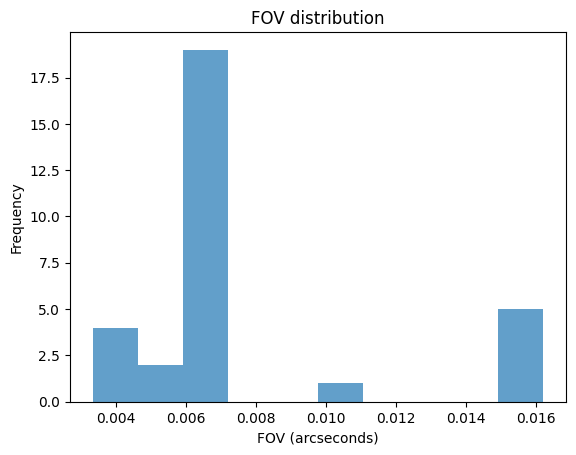

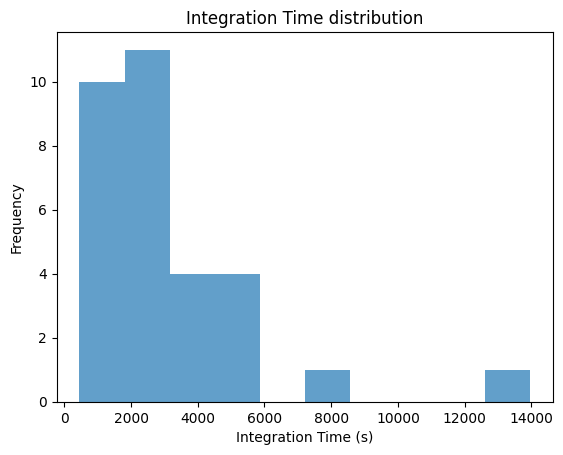

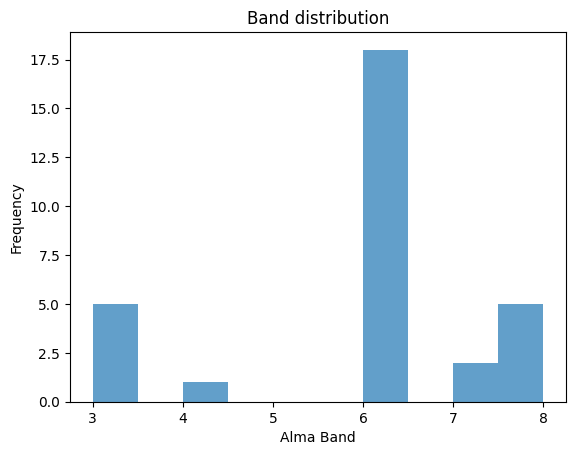

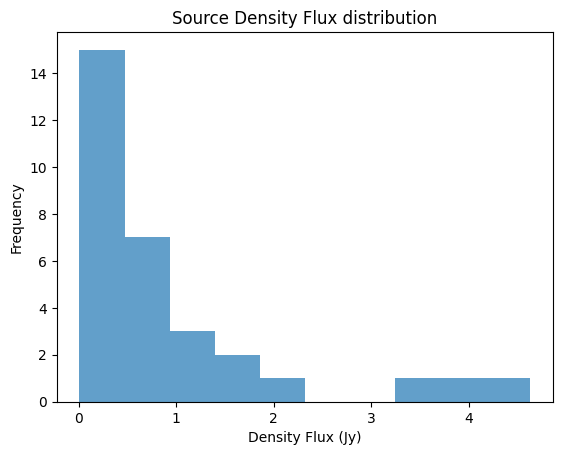

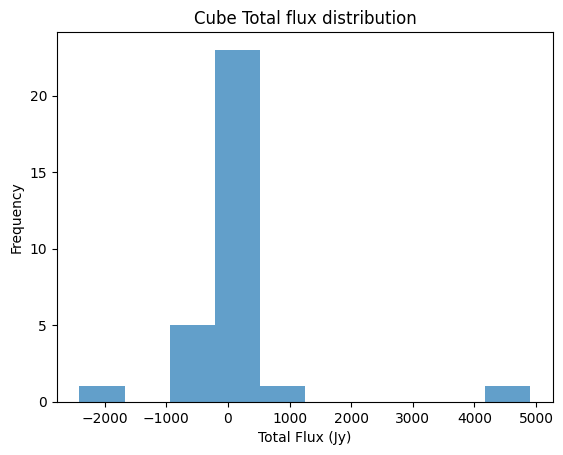

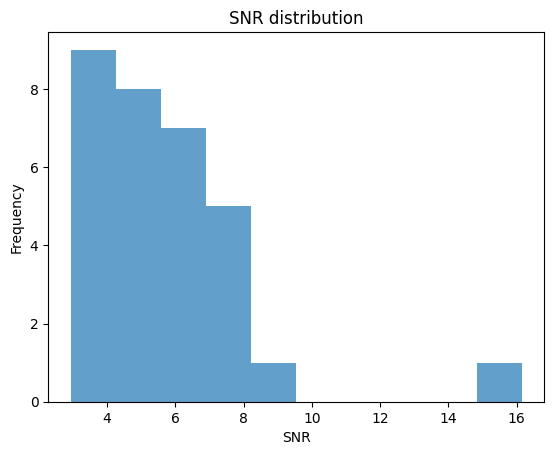

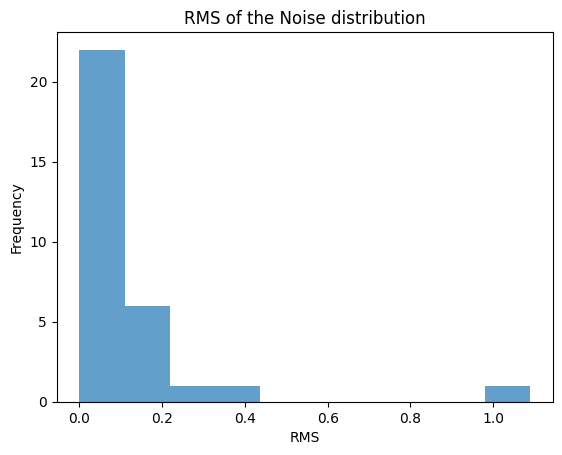

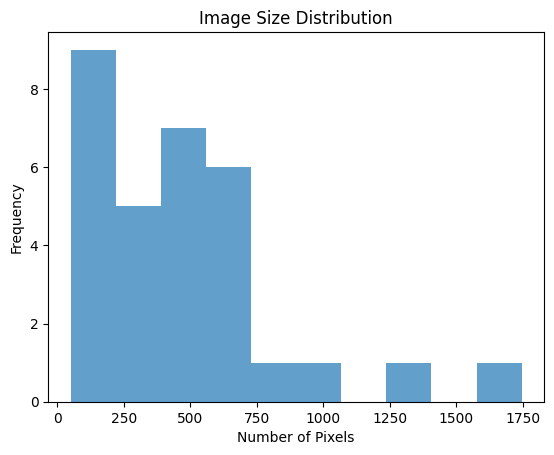

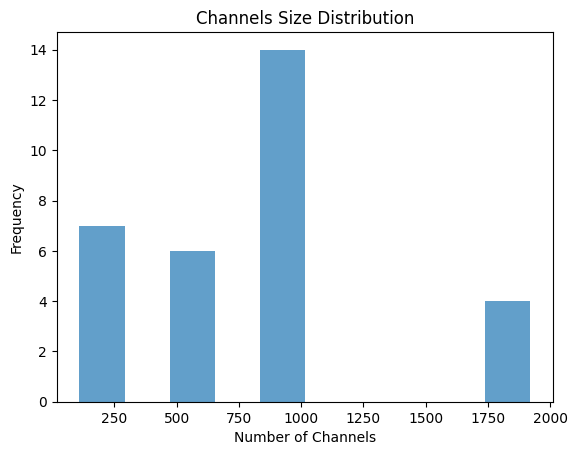

In [4]:
df2 = pd.read_csv(r"C:\Users\lsann\Desktop\GitHub\ALMASim\almasim\metadata\qso_metadata.csv")
df['sb_name'] = df['sb_name'].astype(str)
df_merged = pd.merge(df, df2, left_on='sb_name', right_on='SB_name')

# Selezioniamo le colonne desiderate
columns_to_keep = ['sb_name','FOV', 'Int.Time', 'Band', 'cell_size', 'beam_size', 'source_flux', 'total_flux', 'overall_snr', 'rms_noise', 'n_pixel', 'n_chan']
# Filtriamo il dataframe unito con le colonne specificate
df3 = df_merged[columns_to_keep]

df3['FOV'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('FOV (arcseconds)')
plt.ylabel('Frequency')
plt.title('FOV distribution')
plt.show()

df3['Int.Time'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Integration Time (s)')
plt.ylabel('Frequency')
plt.title('Integration Time distribution')
plt.show()

df3['Band'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Alma Band')
plt.ylabel('Frequency')
plt.title('Band distribution')
plt.show()

df3['source_flux'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Density Flux (Jy)')
plt.ylabel('Frequency')
plt.title('Source Density Flux distribution')
plt.show()

df3['total_flux'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Total Flux (Jy)')
plt.ylabel('Frequency')
plt.title('Cube Total flux distribution')
plt.show()

df3['overall_snr'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('SNR')
plt.ylabel('Frequency')
plt.title('SNR distribution')
plt.show()

df3['rms_noise'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('RMS')
plt.ylabel('Frequency')
plt.title('RMS of the Noise distribution')
plt.show()

df3['n_pixel'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Number of Pixels')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()

df3['n_chan'].plot(kind='hist', bins=10, alpha=0.7)
plt.xlabel('Number of Channels')
plt.ylabel('Frequency')
plt.title('Channels Size Distribution')
plt.show()

In [5]:
print(df3)
print(df3[['source_flux','overall_snr', 'total_flux','rms_noise']].describe())

                        sb_name       FOV  Int.Time  Band  cell_size  \
0              J0842+12_a_06_TE  0.006201    453.60     6   0.149452   
1             J0842+12_a_06_TM1  0.006167   3265.92     6   0.043999   
2             J0842+12_a_08_TM1  0.003326   8074.08     8   0.028961   
3              J1306+03_a_06_TE  0.006153    514.08     6   0.149452   
4             J1306+03_a_06_TM1  0.006153   1693.44     6   0.035389   
5             J1306+03_a_08_TM1  0.003396    514.08     8   0.030646   
6   J1319+0950_266GHz_12m_C32-6  0.006214   2903.04     6   0.039011   
7             J1319+09_a_03_TM1  0.015203   3628.80     3   0.177470   
8             J1319+09_a_08_TM1  0.003404   4536.00     8   0.028961   
9             J1509-17_a_03_TM1  0.015181   3144.96     3   0.247248   
10             J1509-17_a_06_TE  0.006248    483.84     6   0.149452   
11            J1509-17_a_06_TM1  0.006245   2782.08     6   0.038005   
12            J1509-17_b_06_TM1  0.006135   2086.56     6   0.03

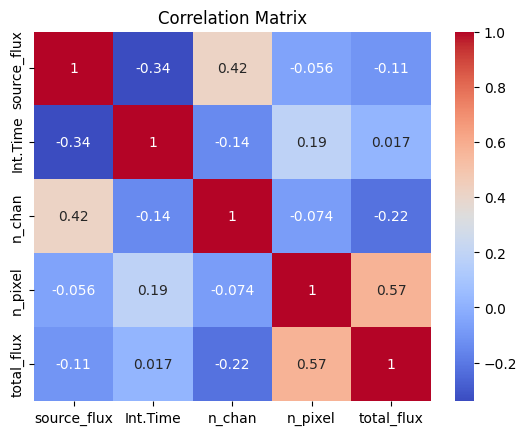

In [6]:
corr_matrix = df3[['source_flux','Int.Time', 'n_chan','n_pixel', 'total_flux']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

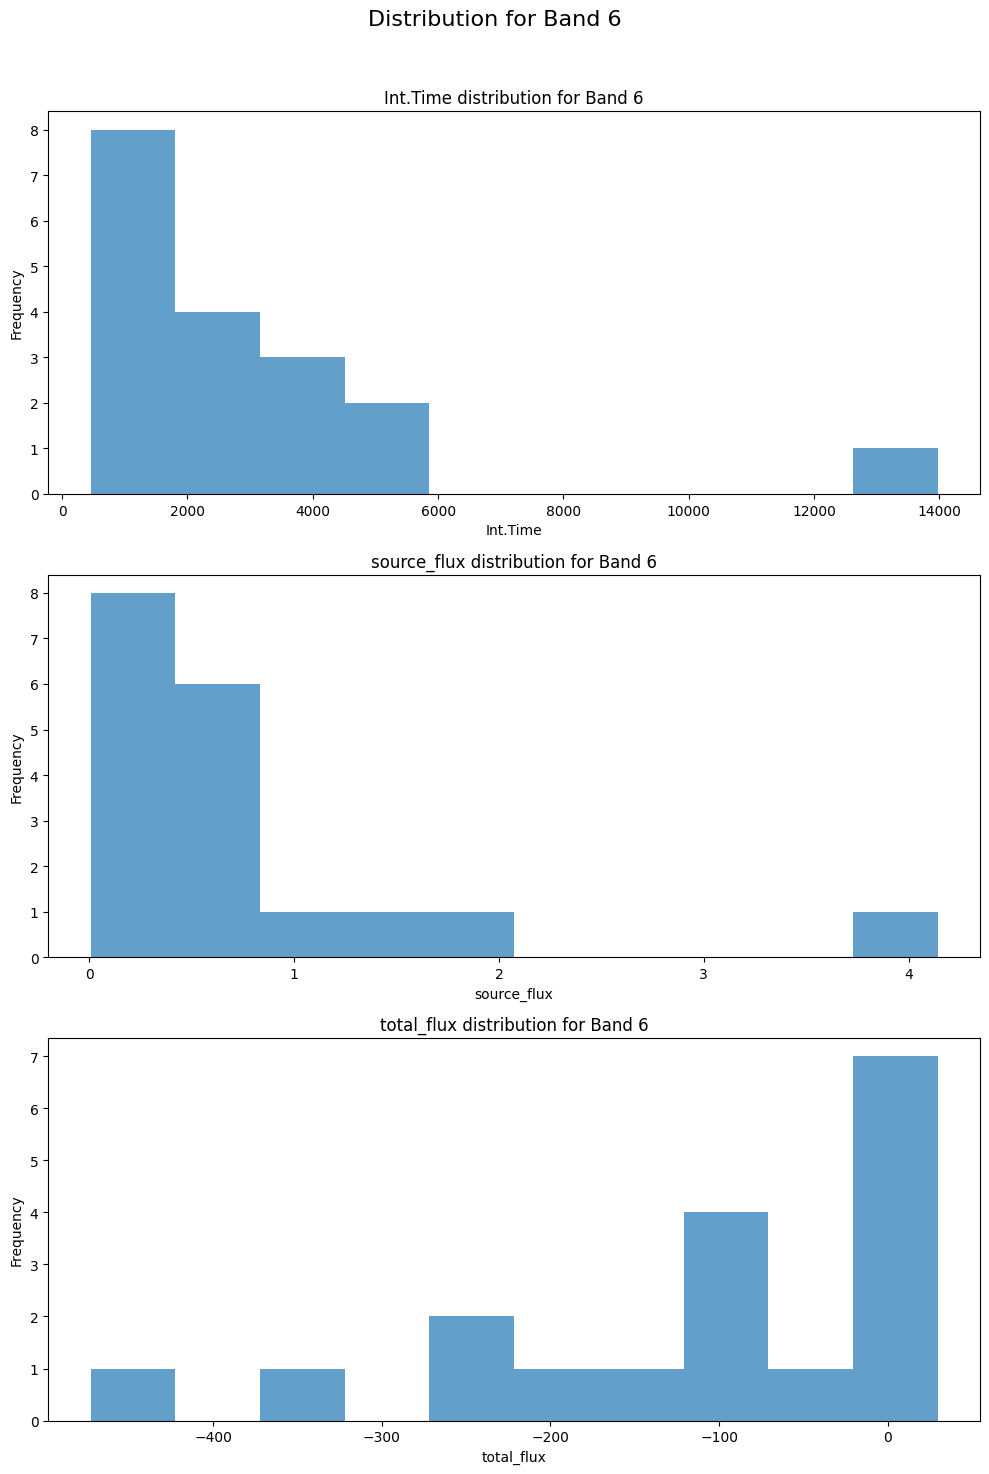

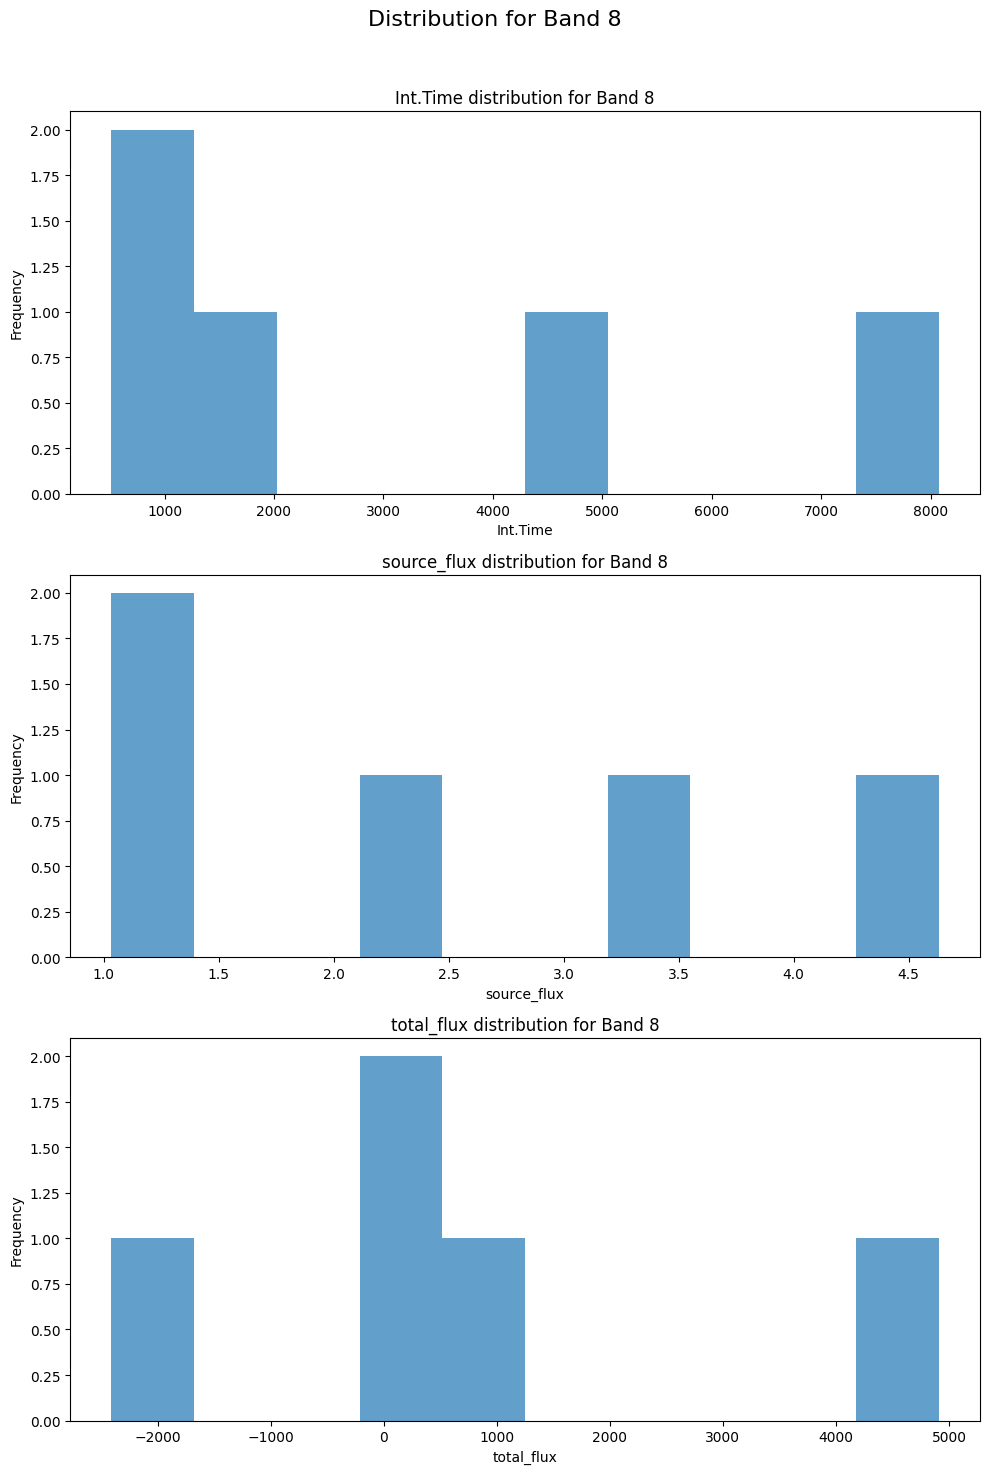

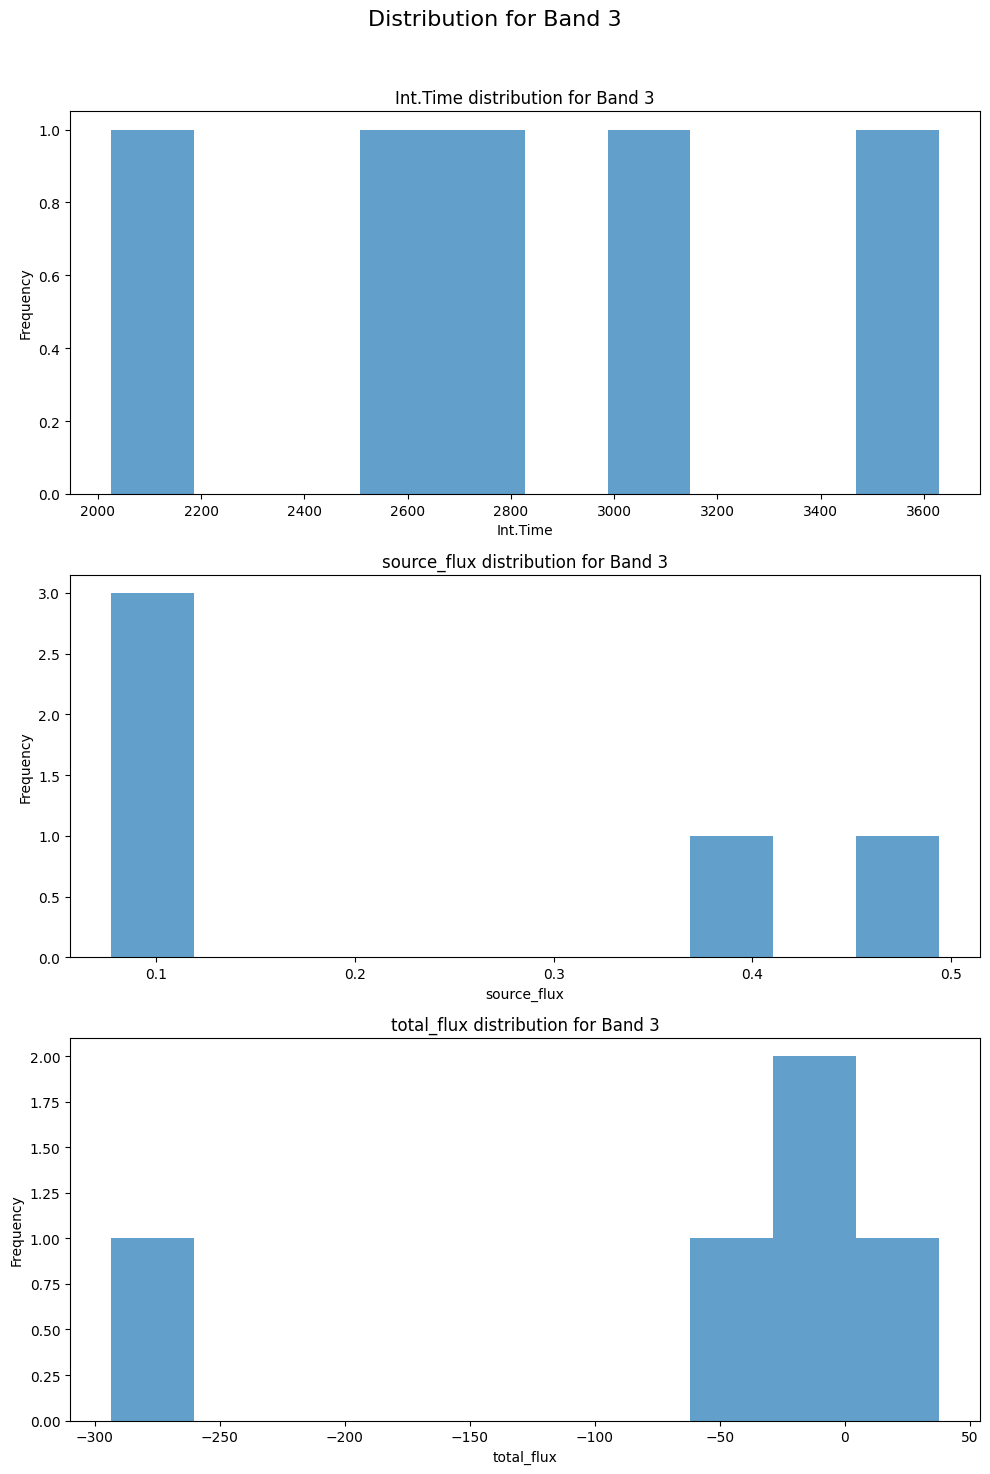

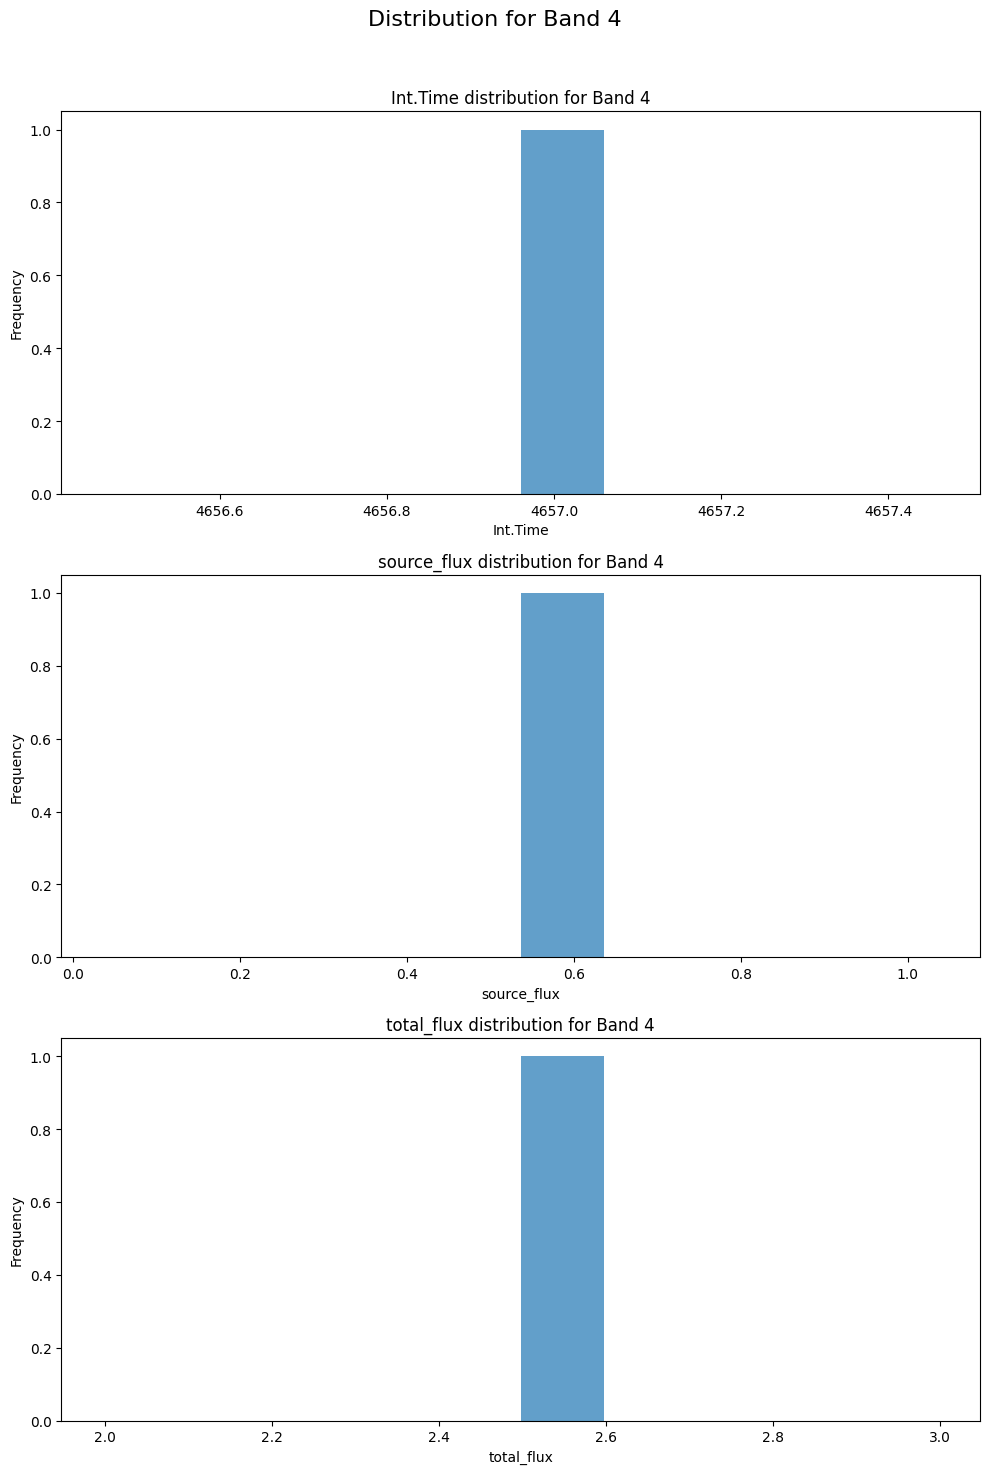

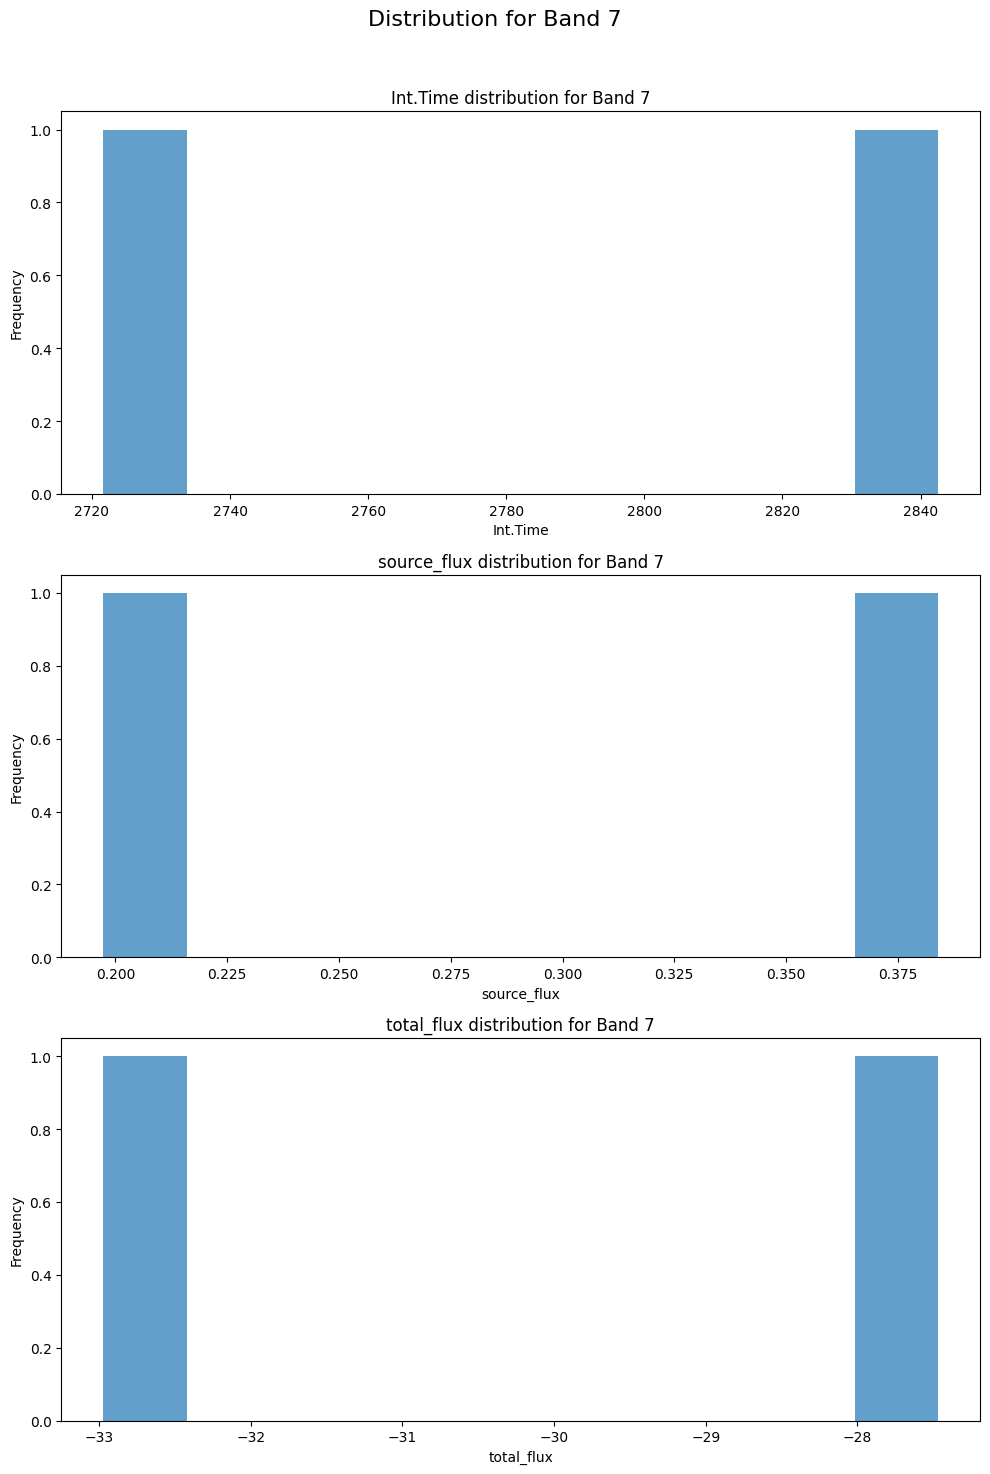

In [7]:
bands = df3['Band'].unique()
columns_to_plot = ['Int.Time', 'source_flux', 'total_flux']

# Crea un grafico per ogni banda
for band in bands:
    band_data = df3[df3['Band'] == band]
    
    # Crea la figura e gli assi per il grafico
    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(10, 5 * len(columns_to_plot)))
    fig.suptitle(f'Distribution for Band {band}', fontsize=16)
    
    # Plot per ogni variabile
    for i, column in enumerate(columns_to_plot):
        ax = axs[i]
        band_data[column].plot(kind='hist', bins=10, alpha=0.7, ax=ax)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.set_title(f'{column} distribution for Band {band}')
    
    # Regola il layout per evitare sovrapposizioni
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



Correlation between Integration Time and Source Flux: -0.34


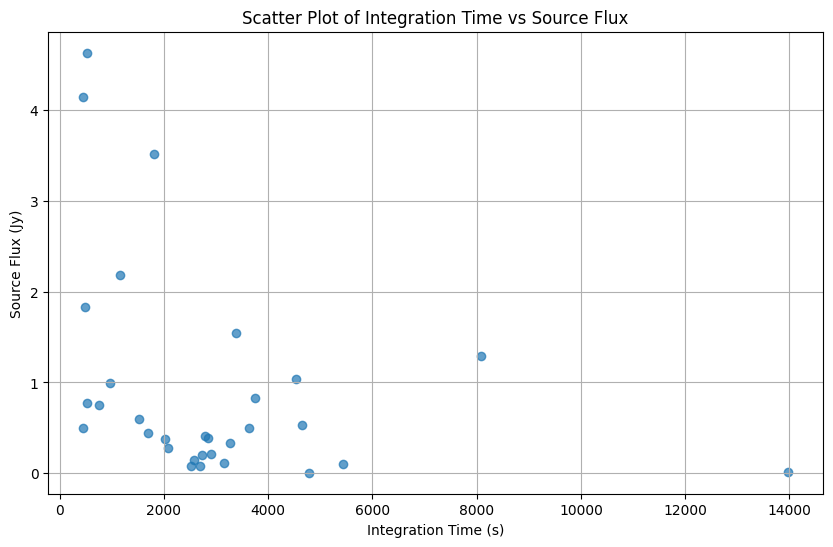

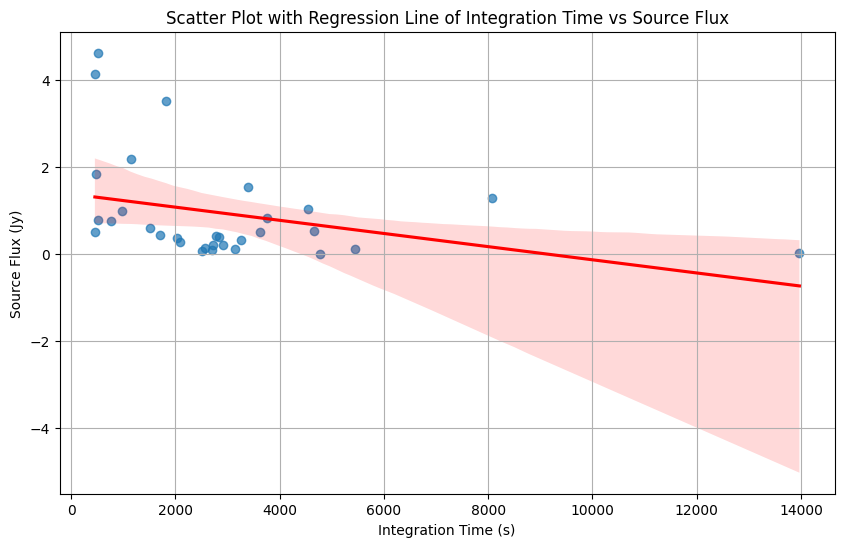

Correlation between Number of Channels and Source Flux: 0.42


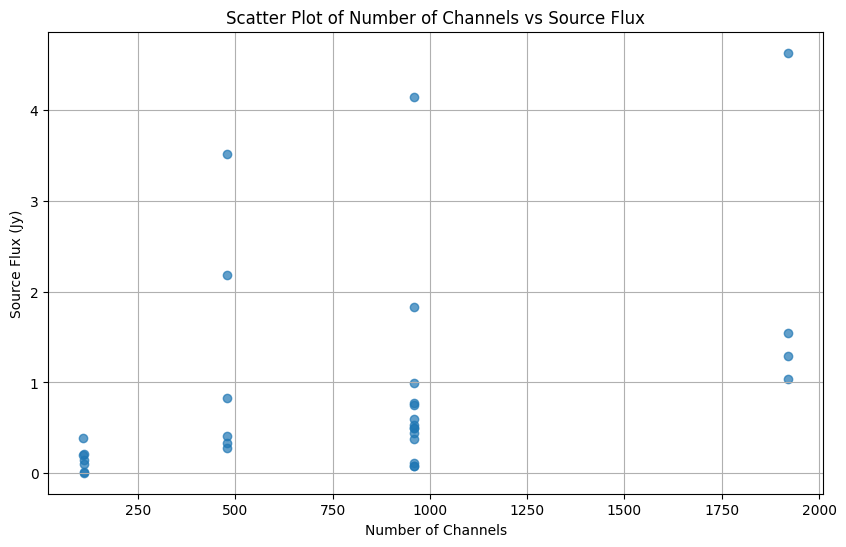

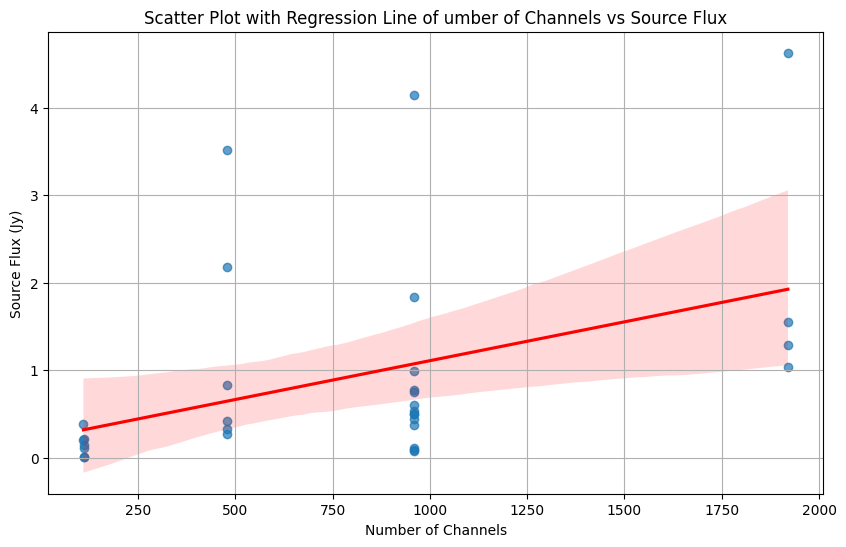

In [8]:
correlation = df3[['Int.Time', 'source_flux']].corr().iloc[0, 1]
print(f"Correlation between Integration Time and Source Flux: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df3['Int.Time'], df3['source_flux'], alpha=0.7)
plt.xlabel('Integration Time (s)')
plt.ylabel('Source Flux (Jy)')
plt.title('Scatter Plot of Integration Time vs Source Flux')
plt.grid(True)
plt.show()

# Scatter plot con linea di regressione
plt.figure(figsize=(10, 6))
sns.regplot(x='Int.Time', y='source_flux', data=df3, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.xlabel('Integration Time (s)')
plt.ylabel('Source Flux (Jy)')
plt.title('Scatter Plot with Regression Line of Integration Time vs Source Flux')
plt.grid(True)
plt.show()

correlation = df3[['n_chan', 'source_flux']].corr().iloc[0, 1]
print(f"Correlation between Number of Channels and Source Flux: {correlation:.2f}")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df3['n_chan'], df3['source_flux'], alpha=0.7)
plt.xlabel('Number of Channels')
plt.ylabel('Source Flux (Jy)')
plt.title('Scatter Plot of Number of Channels vs Source Flux')
plt.grid(True)
plt.show()

# Scatter plot con linea di regressione
plt.figure(figsize=(10, 6))
sns.regplot(x='n_chan', y='source_flux', data=df3, scatter_kws={'alpha':0.7}, line_kws={'color':'red'})
plt.xlabel('Number of Channels')
plt.ylabel('Source Flux (Jy)')
plt.title('Scatter Plot with Regression Line of umber of Channels vs Source Flux')
plt.grid(True)
plt.show()